# Script for Cleanong raw files

In [1]:
#import required libraries|
import os
import pandas as pd
import numpy as np
import datetime
from IPython.display import clear_output
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
%matplotlib inline

# Functions to clean raw data file

In [17]:
def _get_resultants(dataDf):
    """ get resultant columns for 'Accel_LN_', 'Accel_WR_', 'Gyro_','Mag_'

    Args:
        dataDf (data frame): loaded raw dataFrame 

    Returns:
        dataframe: data frame with added resultant columns
    """
    colsNeeded = ['Accel_LN_', 'Accel_WR_', 'Gyro_','Mag_']
    
    for colRes in colsNeeded:
        try:
            dataDf['Resultant_' + colRes] = np.sqrt(np.square(dataDf[colRes + 'X_CAL']) + 
                                            np.square(dataDf[colRes + 'Y_CAL']) + 
                                            np.square(dataDf[colRes + 'Z_CAL']))
        except:
            print("Issue with %s" % colRes)

    return dataDf

def process_rawdata(PATH):
    """Shimmer is not the best in saving csv files. This function takes care of it. Just pass the PATH of file you need

    Args:
        PATH (str): PATH of the file 

    Returns:
        data frame: data loaded and returned as a dataframe
    """
    #read file
    dataDf = pd.read_csv(PATH, sep = '\t', header=0)
    #drop last col with nan
    dataDf.dropna(axis=1, inplace = True)
    #rename cols
    newColNames = [name + '_' + dataDf.iloc[1].values[i] for i,name in enumerate(dataDf.iloc[0].values)]
    # change header
    dataDf = dataDf.set_axis(newColNames, axis=1, inplace=False)[3:].reset_index(drop=True)
    # switch values to float
    dataDf = dataDf.astype(float)
    # get resultant vals
    dataDf = _get_resultants(dataDf)
    # return df
    return dataDf

# String operations

In [18]:
'''
function : digit
--------
'''
def digit_splitter(name, type='d'):
    if type=='d':
        item = ''.join([n for n in name if n.isdigit()])
        item = int(item)
    
    else:
        item = ''.join([n for n in name if not n.isdigit()])
    return item


In [12]:
%ls ../data/clean/tag/e

e_i_sit.csv   e_le_wal.csv  e_n_sta.csv   e_sc_sit.csv  e_sh_wal.csv
e_i_sta.csv   e_m_sit.csv   e_n_wal.csv   e_sc_sta.csv  e_sit_sit.csv
e_i_wal.csv   e_m_sta.csv   e_re_sit.csv  e_sc_wal.csv  e_sta_sta.csv
e_le_sit.csv  e_m_wal.csv   e_re_sta.csv  e_sh_sit.csv  e_wal_wal.csv
e_le_sta.csv  e_n_sit.csv   e_re_wal.csv  e_sh_sta.csv


# Load raw data and tags Files

In [13]:
fileName = "a_m_sit.csv"
tagsDf = pd.read_csv("../data/unclean/tags/b/b_m_sit.csv", index_col=[0])
dataDf = process_rawdata("../data/unclean/raw/b/20210910171401b_m_sit.csv")
tagsDf['time'] = pd.to_datetime(tagsDf.time) + datetime.timedelta(0,1)

In [14]:
import datetime
datetime.datetime.strptime('20210910105115', "%Y%m%d%H%M%S") + datetime.timedelta(0,1)

datetime.datetime(2021, 9, 10, 10, 51, 16)

In [15]:
dataDf['TimeStamp'] = [datetime.datetime.strptime('20210910105115', "%Y%m%d%H%M%S") +
                       datetime.timedelta(0,v/51) for v in dataDf.index+1]

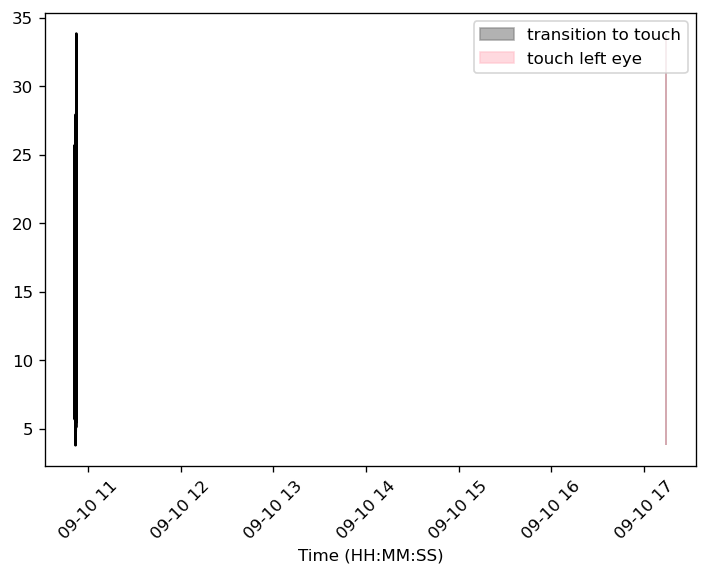

In [38]:
plt.figure(figsize = (7,5),dpi=120)

#plt.plot(dataDf.TimeStamp[2000:3000],dataDf.Resultant_Accel_LN_[:1000])

plt.plot(dataDf.TimeStamp[20:],dataDf.Resultant_Accel_LN_[20:], color='black')


# plt.plot(dataDf.TimeStamp[2000:3000],dataDf.Accel_LN_X_CAL[2000:3000], label = 'x-Accel')
# plt.plot(dataDf.TimeStamp[2000:3000],dataDf.Accel_LN_Y_CAL[2000:3000], label = 'y-Accel')
# plt.plot(dataDf.TimeStamp[2000:3000],dataDf.Accel_LN_Z_CAL[2000:3000], label = 'z-Accel')

plt.xticks(rotation=45)

# d = data['Date'].values
# plt.fill_between(d, data['A'], data['B'],
#                 where=data['A'] >= data['B'],
#                 facecolor='green', alpha=0.2, interpolate=True)


for i,bar in enumerate(tagsDf.values.reshape(17,3,2)[10:15]):
    times = np.take(bar,0, axis=1)
    times = [t - datetime.timedelta(0,1) for t in times]
    a = times[0]
    b = times[1]
    vals = dataDf.Resultant_Accel_LN_[20:]
    #vals = [0,25]
    if i==0:
        plt.fill_between([times[0],times[1]], np.min(vals), np.max(vals), alpha =0.6, color = 'gray', label = "transition to touch")
        plt.fill_between([times[1],times[2]], np.min(vals), np.max(vals), alpha =0.6, color = 'pink', label = "touch left eye")
    else:
        plt.fill_between([times[0],times[1]], np.min(vals), np.max(vals), alpha =0.6, color = 'gray')
        plt.fill_between([times[1],times[2]], np.min(vals), np.max(vals), alpha =0.6, color = 'pink')
        
plt.xlabel("Time (HH:MM:SS)")
    #plt.fill_between([times[1],times[2]], np.min(vals), np.max(vals), alpha =0.6, color = 'yellow')

    # #     plt.fill_between(np.take(bar,0))
    
# #     print(np.take(bar,0))
# #     pos= np.sum(np.take(bar,0))
# #     print(pos)
#     plt.bar(np.take(bar,0), 27.5, datetime.timedelta(0,20))
    
#     val= [max_val]
#     width = [bar[2][0]-bar[0][0]]
#     ax2.bar(pos,val,width, color = 'black', alpha = 0.1)
plt.legend()
plt.savefig("r.png")
plt.show()
#plt.bar()
%matplotlib inline

In [27]:
tagsDf.values.shape[0][1].shape

TypeError: 'int' object is not subscriptable

In [211]:
tagsDf.values.reshape(27,3,2)[:4]

array([[[Timestamp('2021-09-10 10:51:18.262964'), 't'],
        [Timestamp('2021-09-10 10:51:18.868621'), 'y'],
        [Timestamp('2021-09-10 10:51:19.556485'), 'u']],

       [[Timestamp('2021-09-10 10:51:20.405710'), 't'],
        [Timestamp('2021-09-10 10:51:20.976593'), 'y'],
        [Timestamp('2021-09-10 10:51:21.534269'), 'u']],

       [[Timestamp('2021-09-10 10:51:22.402140'), 't'],
        [Timestamp('2021-09-10 10:51:22.926471'), 'y'],
        [Timestamp('2021-09-10 10:51:23.642457'), 'u']],

       [[Timestamp('2021-09-10 10:51:24.369033'), 't'],
        [Timestamp('2021-09-10 10:51:25.001542'), 'y'],
        [Timestamp('2021-09-10 10:51:25.644294'), 'u']]], dtype=object)

In [203]:
bar

array([Timestamp('2021-09-10 10:51:26.539843'), 't'], dtype=object)

In [171]:
81/3

27.0